In [1]:
folder = '../logs/mushrooms2/scenario_1'
arch = 'generative_agents'
llm_model = 'gpt4o'

In [2]:
import os

simulations_folder = os.path.join(folder, arch, llm_model)
sim_folder = os.listdir(simulations_folder)[0]
sim_folder_path = os.path.join(simulations_folder, sim_folder)
sim_log_file = os.path.join(sim_folder_path, '2024-09-19--08-48-15.log')

In [3]:
turn_start_pat = r'^################Agent\'s (\w+) turn################'
prompt_start_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:182 - Prompt:'
prompt_end_pat = r'^None - step_0 - INFO - httpx - _send_single_request:1013 - HTTP Request: POST https://api\.openai\.com/v1/chat/completions'
invalid_act_prompt_pat =r'^step \d+ - step_\d+ - WARNING - agent.cognitive_modules.act - actions_sequence:70 - Could not find action in the response_dict'
act_prompt_unique_feat_pat = r'^\s+"Consequences":\s+string+\s+[\\]+\s+.+'
response_start_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:185 - Response:'
response_end_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:188 - Prompt tokens: \d+'
game_observations_pat = r'^step \d+ - step_\d+ - INFO - __main__ - game_loop:60 - \w+ Observations: '

In [4]:
import re
import numbers

def extract_prompts(sim_log_file, type = None):
    cot_agent_prompt = type == 'cot_agent'
    # init flags
    prompt_flags = dict(
        is_prompt_start = False,
        is_act_prompt = False
    )
    response_flags = dict(
        is_response_start = False,
    )
    turn_flags = dict( # This flags are reset when the turn change
        act_response_successful = False
    )
    prompt_response_pair_flags = dict( # This flags can be set between the prompt start and response end, are reinitialized after the response end
        act_prompt_called = False
    )
    stats = dict(
        total_prompts = 0,
        total_turns = 0,
        invalid_prompts = 0,
        act_prompts = 0,
    )
    tmp_prompt_data = dict(
        prompt_content = '',
    )
    tmp_response_data = dict(
        response_content = '',
    )
    tmp_turn_data = dict( # This info is only available while the turn has not changed
        game_observations = ''
    )
    accum_data = dict(
        act_prompts_content = [],
        act_prompts_response = [],
        game_observations_for_act = []
    )
    agent = None

    def reset_flags(flags_dicts):
        for flag in flags_dicts:
            if isinstance(flags_dicts[flag], bool):
                flags_dicts[flag] = False
            elif isinstance(flags_dicts[flag], numbers.Number):
                flags_dicts[flag] = 0
            elif isinstance(flags_dicts[flag], str):
                flags_dicts[flag] = ''
            else:
                raise Exception(f'Unsupported type of flag: {type(flags_dicts[flag])}')
            
    def end_turn_hook():
        stats['total_turns'] += 1
        if tmp_turn_data['game_observations'] and turn_flags['act_response_successful']:
            accum_data['game_observations_for_act'].append(tmp_turn_data['game_observations'])

    def end_prompt_hook(prompt_flags, stats, accum_data, tmp_prompt_data, turn_flags):
        stats['total_prompts'] += 1

        # Is it was an act prompt save it
        if prompt_flags['is_act_prompt']:
            stats['act_prompts'] += 1
            accum_data['act_prompts_content'].append(tmp_prompt_data['prompt_content'])
            prompt_response_pair_flags['act_prompt_called'] = True

        reset_flags(tmp_prompt_data)
        reset_flags(prompt_flags)


    with open(sim_log_file) as file:
        for line in file:
            ###### Turns

            # Check if it is a new turn
            is_new_turn = re.match(turn_start_pat, line)
            if is_new_turn:
                agent = is_new_turn.group(1)

                end_turn_hook()

                # Reset flags
                reset_flags(turn_flags)
                reset_flags(tmp_turn_data)
                if prompt_flags['is_prompt_start']:
                    print('There was a prompt ending that was not catch')
                    reset_flags(tmp_prompt_data)
                    reset_flags(prompt_flags)
                if response_flags['is_response_start']:
                    print('There was a response ending that was not catch')
                    reset_flags(tmp_response_data)
                    reset_flags(response_flags)

            ###### Prompts
            
            # Check if a prompt starts
            prompt_start_match = re.match(prompt_start_pat, line)
            if prompt_start_match:
                prompt_flags['is_prompt_start'] = True

            # Check if a prompt ends
            prompt_end_match = re.match(prompt_end_pat, line)
            if prompt_flags['is_prompt_start'] and prompt_end_match:
                end_prompt_hook(prompt_flags, stats, accum_data, tmp_prompt_data, turn_flags)

            # Check if the prompt was invalid
            if (not prompt_flags['is_prompt_start']) and re.match(invalid_act_prompt_pat, line):
                stats['invalid_prompts'] += 1
                stats['act_prompts'] -= 1
                # Delete the last act prompt
                accum_data['act_prompts_content'] = accum_data['act_prompts_content'][:-1]
                prompt_response_pair_flags['act_prompt_called'] = False
                accum_data['act_prompts_response'] = accum_data['act_prompts_response'][:-1]
                turn_flags['act_response_successful'] = False

            # Check if it is an act prompt
            act_prompt_match = prompt_flags['is_prompt_start'] and re.match(act_prompt_unique_feat_pat, line)
            if cot_agent_prompt: # The only prompt is the act prompt
                act_prompt_match = prompt_flags['is_prompt_start']
            if act_prompt_match:
                prompt_flags['is_act_prompt'] = True

            # Save the prompt_content
            if prompt_flags['is_prompt_start']:
                tmp_prompt_data['prompt_content'] += line

            ###### Prompt Responses

            # Check if a prompt response starts
            if (not prompt_flags['is_prompt_start']) and re.match(response_start_pat, line):
                response_flags['is_response_start'] = True

            # Save the response content
            if response_flags['is_response_start']:
                tmp_response_data['response_content'] += line

            # Check if the response ends
            if response_flags['is_response_start'] and re.match(response_end_pat, line):
                response_flags['is_response_start'] = False
                if prompt_response_pair_flags['act_prompt_called']:
                    accum_data['act_prompts_response'].append(tmp_response_data['response_content'])
                    turn_flags['act_response_successful'] = True
                reset_flags(tmp_response_data)
                reset_flags(response_flags)
                reset_flags(prompt_response_pair_flags)

            ###### Game observations
            if (not prompt_flags['is_prompt_start']) and (not response_flags['is_response_start']) and re.match(game_observations_pat, line):
                tmp_turn_data['game_observations'] = line


    print('total prompts:', stats['total_prompts'], 'invalid_prompts:', stats['invalid_prompts'], 'act_prompts', stats['act_prompts'], len(accum_data['act_prompts_content']), \
        'act_responses:', len(accum_data['act_prompts_response']))
    return accum_data

In [5]:
accum_data = extract_prompts(sim_log_file)

total prompts: 172 invalid_prompts: 2 act_prompts 22 22 act_responses: 22


In [6]:
import ast
import os
import sys
import numpy as np
sys.path.append(os.path.abspath('../'))
from game_environment.utils import connected_elems_map, get_local_position_from_global
from utils.math import manhattan_distance


def get_scene_info(observations):
    scene_description_pat = r'.+\], Scene descriptions: (\{.+)'
    scene_info = re.match(scene_description_pat, observations).group(1)
    scene_info = ast.literal_eval(scene_info)
    return scene_info


def get_act_reponse(act_prompt_response, cot_agent_prompt = False):
    action_pat = r'\s*"[Aa]nswer":\s+"(.+?)"'
    action = re.search(action_pat, act_prompt_response, re.MULTILINE).group(1)
    return action


def get_relevant_info_from_observations(observations):
    matrix = np.array([list(row) for row in observations['observation'].split('\n') if row != ''])
    mushroom_types = ['F', 'H', 'Z', 'N']
    mushrooms_info = {}
    for mushroom in mushroom_types:
        rows, columns = np.where(matrix == mushroom)
        mushrooms_info[mushroom] = list(zip(rows, columns))

    return {'mushrooms': mushrooms_info, 'map': matrix}

def score_action(scene_info, observations, action):
    agent_ids = ['0', '1', '2', '3', '4', '5', '6', '7']
    OBS_WINDOW_SIZE = (11, 11)
    action_name = None

    if re.match(r'explore', action, re.IGNORECASE):
        action_name = 'explore'
        # If there are no green nor red mushrooms
        if len(scene_info['mushrooms']['F']) == 0 and len(scene_info['mushrooms']['H']) == 0:
            return action_name, 1
        else:
            return action_name, 0
    elif re.match(r'go to', action, re.IGNORECASE):
        action_name = 'go_to'
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                # If no green nor red mushrooms
                if len(scene_info['mushrooms']['F']) == 0 and len(scene_info['mushrooms']['H']) == 0:
                    return action_name, 1
                else:
                    return action_name, 0
            # If the destination is a red mushroom
            elif scene_info['map'][destination[0], destination[1]] == 'F':
                # If there where no green mushrooms
                if len(scene_info['mushrooms']['H']) == 0:
                    return action_name, 1
                else:
                    return action_name, 0.8
            # If the destination is a green mushroom
            elif scene_info['map'][destination[0], destination[1]] == 'H':
                return action_name, 1
            else:
                return action_name, 0
        else:
            return action_name, 0
    elif re.match(r'stay\s+put', action, re.IGNORECASE):
        # If there no green mushrooms
        if len(scene_info['mushrooms']['H']) == 0:
            return 'stay_put', 0.5
        else:
            return 'stay_put', 0
    else:
        action_name = 'unknow'
        print(f'ERROR: action was not catch "{action}"')
        return action_name, 0

def eval_action(raw_observations, act_prompt_response, type= None, score_action_fn = None):
    cot_agent_prompt = type == 'cot_agent'
    # print('raw_observations', raw_observations)
    observations = get_scene_info(raw_observations)
    scene_info = get_relevant_info_from_observations(observations)
    # print(scene_info)
    action = get_act_reponse(act_prompt_response, cot_agent_prompt=cot_agent_prompt)
    # print(action)
    return score_action_fn(scene_info, observations, action)

In [43]:
def get_file_score(file_data, type=None, score_action_fn = score_action):
    file_scores = {}
    for i in range(len(file_data['game_observations_for_act'])):
        action_name, score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=score_action_fn)
        file_scores[action_name] = file_scores.get(action_name, []) + [score]
        file_scores['total'] = file_scores.get('total', []) + [score]

    for key in file_scores.keys():
        file_scores[key] = sum(file_scores[key])/len(file_scores[key]), len(file_scores[key])
    return file_scores

get_file_score(accum_data)

{'go_to': (0.7529411764705882, 17), 'total': (0.8, 21), 'explore': (1.0, 4)}

## Get scores for all the files of an arch with a llm

In [44]:
def evaluate_the_complete_scenario(folder, file_score_fn = get_file_score):
    results = {}

    for arch in os.listdir(folder):
        results[arch] = {}
        for llm_model in os.listdir(os.path.join(folder, arch)):
            simulations_folder = os.path.join(folder, arch, llm_model)
            sim_scores = []
            for sim_folder in os.listdir(simulations_folder):
                log_filename = re.search(r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}', sim_folder).group(0) + '.log'
                log_path = os.path.join(simulations_folder, sim_folder, log_filename)
                file_raw_info = extract_prompts(log_path, type=arch)
                try:
                    score = file_score_fn(file_raw_info, type=arch)
                except Exception as e:
                    print('log_path', log_path)
                    print('file_raw_info', file_raw_info)
                    raise Exception(e)
                sim_scores.append(score)
            results[arch][llm_model] = sim_scores

    return results

In [45]:
results = evaluate_the_complete_scenario(folder)
results

total prompts: 1195 invalid_prompts: 0 act_prompts 167 167 act_responses: 167
total prompts: 635 invalid_prompts: 0 act_prompts 69 69 act_responses: 69
total prompts: 969 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 1146 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 792 invalid_prompts: 0 act_prompts 93 93 act_responses: 93
total prompts: 1655 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 491 invalid_prompts: 0 act_prompts 57 57 act_responses: 57
total prompts: 972 invalid_prompts: 0 act_prompts 112 112 act_responses: 112
total prompts: 700 invalid_prompts: 0 act_prompts 107 107 act_responses: 107
total prompts: 429 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 172 invalid_prompts: 2 act_prompts 22 22 act_responses: 22
total prompts: 664 invalid_prompts: 10 act_prompts 72 72 act_responses: 72
total prompts: 482 invalid_prompts: 7 act_prompts 71 71 act_responses: 71
total prompts: 1432

{'generative_agents': {'gpt4o_mini': [{'go_to': (0.5529411764705882, 119),
    'total': (0.5916167664670658, 167),
    'stay_put': (0.4782608695652174, 23),
    'explore': (0.88, 25)},
   {'go_to': (0.7306122448979593, 49),
    'total': (0.6855072463768116, 69),
    'stay_put': (0.5, 17),
    'explore': (1.0, 3)},
   {'stay_put': (0.5, 11),
    'total': (0.7846938775510203, 98),
    'go_to': (0.8027027027027026, 74),
    'explore': (0.9230769230769231, 13)},
   {'go_to': (0.7168316831683169, 101),
    'total': (0.72578125, 128),
    'stay_put': (0.3888888888888889, 9),
    'explore': (0.9444444444444444, 18)},
   {'go_to': (0.5918918918918918, 74),
    'total': (0.6161290322580645, 93),
    'stay_put': (0.45, 10),
    'explore': (1.0, 9)},
   {'go_to': (0.7007633587786259, 131),
    'total': (0.6645714285714286, 175),
    'stay_put': (0.44285714285714284, 35),
    'explore': (1.0, 9)},
   {'go_to': (0.596078431372549, 51),
    'total': (0.612280701754386, 57),
    'explore': (1.0, 3),


In [46]:
# results = evaluate_the_complete_scenario(folder)
keys = ['total', 'explore', 'go_to', 'stay_put']
for key in keys:
    print(key)
    for arch in results:
        for llm_model in results[arch]:
            scores = list(filter(lambda x: key in x, results[arch][llm_model]))
            support = sum(map(lambda x: x[key][1], scores))
            scores = list(map(lambda x: x[key][0], scores))
            print(f'{arch} - {llm_model}: {np.mean(scores):.2f} - support: {support}')

total
generative_agents - gpt4o_mini: 0.63 - support: 1066
generative_agents - gpt4o: 0.62 - support: 1033
cot_agent - gpt4o_mini: 0.71 - support: 648
cot_agent - gpt4o: 0.64 - support: 495
explore
generative_agents - gpt4o_mini: 0.92 - support: 122
generative_agents - gpt4o: 0.86 - support: 160
cot_agent - gpt4o_mini: 0.78 - support: 198
cot_agent - gpt4o: 0.85 - support: 124
go_to
generative_agents - gpt4o_mini: 0.62 - support: 792
generative_agents - gpt4o: 0.61 - support: 759
cot_agent - gpt4o_mini: 0.68 - support: 441
cot_agent - gpt4o: 0.57 - support: 370
stay_put
generative_agents - gpt4o_mini: 0.45 - support: 152
generative_agents - gpt4o: 0.28 - support: 114
cot_agent - gpt4o_mini: 0.25 - support: 9
cot_agent - gpt4o: 0.50 - support: 1


In [47]:
def prefer_green_over_red(scene_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None
            
            # If there were green and red mushrooms
            if len(scene_info['mushrooms']['H']) == 0 or len(scene_info['mushrooms']['F']) == 0:
                return None
            
            # If took a green mushroom
            if scene_info['map'][destination[0], destination[1]] == 'H':
                return True
            # If took a red mushroom
            if scene_info['map'][destination[0], destination[1]] == 'F':
                return False

    return None
            

In [54]:
def get_file_prefer_green_over_red(file_data, type=None):
    scenario_results = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=prefer_green_over_red)
        if action_score is not None:
            scenario_results.append(action_score)
    
    times_scenario_seen = sum(scenario_results)
    if not len(scenario_results):
        return None, 0
    return times_scenario_seen / len(scenario_results), len(scenario_results)
get_file_prefer_green_over_red(accum_data)

(0.5, 2)

In [49]:
results = evaluate_the_complete_scenario(folder, get_file_prefer_green_over_red)

total prompts: 1195 invalid_prompts: 0 act_prompts 167 167 act_responses: 167
total prompts: 635 invalid_prompts: 0 act_prompts 69 69 act_responses: 69
total prompts: 969 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 1146 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 792 invalid_prompts: 0 act_prompts 93 93 act_responses: 93
total prompts: 1655 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 491 invalid_prompts: 0 act_prompts 57 57 act_responses: 57
total prompts: 972 invalid_prompts: 0 act_prompts 112 112 act_responses: 112
total prompts: 700 invalid_prompts: 0 act_prompts 107 107 act_responses: 107
total prompts: 429 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 172 invalid_prompts: 2 act_prompts 22 22 act_responses: 22
total prompts: 664 invalid_prompts: 10 act_prompts 72 72 act_responses: 72
total prompts: 482 invalid_prompts: 7 act_prompts 71 71 act_responses: 71
total prompts: 1432

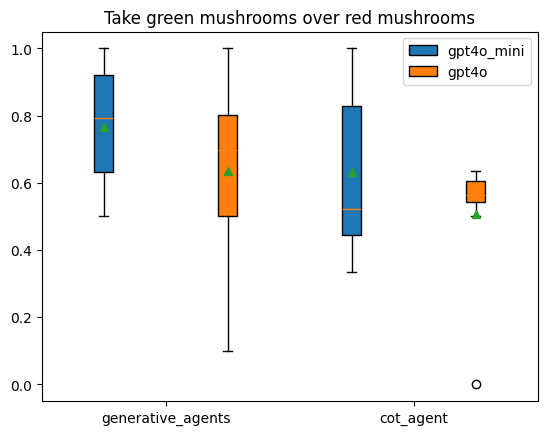

In [56]:
positions = np.arange(4)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        # Filter results in None
        model_results = list(filter(lambda x: x[0] is not None, model_results))
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks([0.5, 2.5], results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Take green mushrooms over red mushrooms')
plt.show()

In [70]:
def explore_when_green_mushrooms(scene_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    # If there are no green mushrooms
    if len(scene_info['mushrooms']['H']) == 0:
        # Did not go to ant other mushroom
        if re.match(r'explore', action, re.IGNORECASE):
            return True
        elif re.match(r'go to', action, re.IGNORECASE):
            destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
            if destination:
                destination = tuple(map(int, destination.group(1).split(',')))
                destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
                # If the destintation is out of the observation window
                if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                    return True
                # If the destination is a red mushroom
                elif scene_info['map'][destination[0], destination[1]] in ['Z', 'N']:
                    return False
                else:
                    return True
            else:
                return True
        else:
            return True
    return None

In [71]:
def get_file_explore_when_green_mushrooms(file_data, type=None):
    scenario_results = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=explore_when_green_mushrooms)
        if action_score is not None:
            scenario_results.append(action_score)
    
    times_scenario_seen = sum(scenario_results)
    if not len(scenario_results):
        return None, 0
    return times_scenario_seen / len(scenario_results), len(scenario_results)
get_file_explore_when_green_mushrooms(accum_data)

(0.9285714285714286, 14)

In [72]:
results = evaluate_the_complete_scenario(folder, get_file_explore_when_green_mushrooms)

total prompts: 1195 invalid_prompts: 0 act_prompts 167 167 act_responses: 167
total prompts: 635 invalid_prompts: 0 act_prompts 69 69 act_responses: 69
total prompts: 969 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 1146 invalid_prompts: 0 act_prompts 128 128 act_responses: 128
total prompts: 792 invalid_prompts: 0 act_prompts 93 93 act_responses: 93
total prompts: 1655 invalid_prompts: 1 act_prompts 175 175 act_responses: 175
total prompts: 491 invalid_prompts: 0 act_prompts 57 57 act_responses: 57
total prompts: 972 invalid_prompts: 0 act_prompts 112 112 act_responses: 112
total prompts: 700 invalid_prompts: 0 act_prompts 107 107 act_responses: 107
total prompts: 429 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 172 invalid_prompts: 2 act_prompts 22 22 act_responses: 22
total prompts: 664 invalid_prompts: 10 act_prompts 72 72 act_responses: 72
total prompts: 482 invalid_prompts: 7 act_prompts 71 71 act_responses: 71
total prompts: 1432

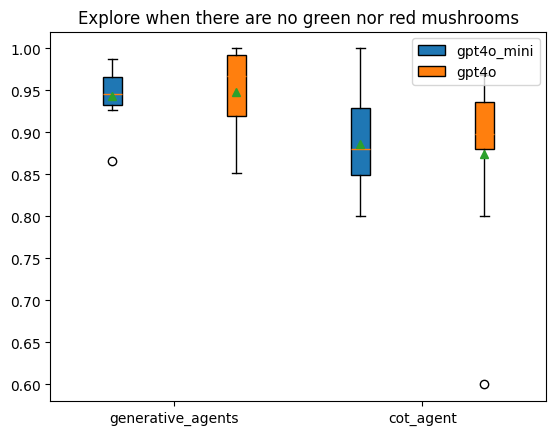

In [74]:
positions = np.arange(4)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        # Filter results in None
        model_results = list(filter(lambda x: x[0] is not None, model_results))
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks([0.5, 2.5], results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Explore when there are no green nor red mushrooms')
plt.show()